# Load Data

In [0]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:


trDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load('./drive/My Drive/Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (3835, 224, 224, 3), (3835,), (959, 224, 224, 3), (959,)


Showing 560 index image, It is 0.0


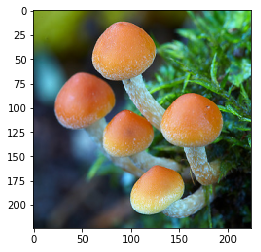

Showing 950 index image, It is 0.0


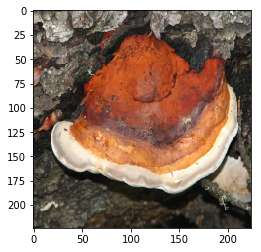

Showing 751 index image, It is 0.0


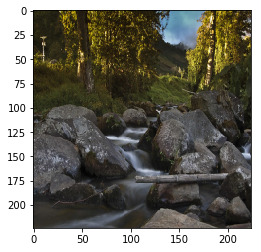

Showing 915 index image, It is 0.0


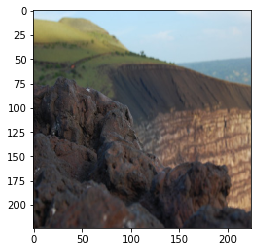

Showing 945 index image, It is 0.0


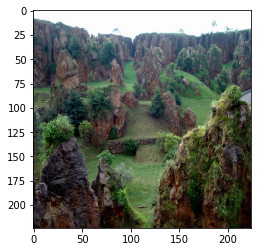

In [3]:
# Randomly show 10 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(5):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# # reshape the data to be [samples][width][height][channel]
# # This is required by Keras framework
# trDat       = trDat.reshape(trDat.shape[0], imgrows, imgclms, channel)
# tsDat       = tsDat.reshape(tsDat.shape[0], imgrows, imgclms, channel)

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

# Define Model

In [8]:
# fix random seed for reproducibility
# seed = 29
# np.random.seed(seed)

modelname = 'FlowerPower_VGG16'
optmz     = optimizers.RMSprop(lr=0.0001)
# optmz     = 'adam'

def createVGG16Model():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz,
                  metrics=['accuracy'])
    return model

def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 110:
        lr  *= 0.5e-3
        
    elif epoch > 100:
        lr  *= 1e-3
        
    elif epoch > 90:
        lr  *= 1e-2
        
    elif epoch > 70:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)
  
def createBaselineModel():
    inputs = Input(shape=(imgrows, imgclms, channel))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[inputs],outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
  
# model = createVGG16Model()
# modelGo = createVGG16Model()

model = createBaselineModel()
modelGo = createBaselineModel()

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0   

In [0]:
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
#                                  monitor='val_acc', 
                                  monitor='val_loss',
                                  verbose=0, 
                                  save_best_only=True, 
#                                  mode='max')
                                  mode='min')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint, csv_logger, LRScheduler]
# callbacks_list  = [checkpoint, csv_logger]

In [10]:
# Fit the model
# This is where the training starts
# model.fit(trDat, 
#           trLbl, 
#           validation_data=(tsDat, tsLbl), 
#           epochs=120, 
#           batch_size=16,
#           callbacks=callbacks_list)

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=30,
                             horizontal_flip=True,
                             vertical_flip=False)

model.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=120, 
                    verbose=1,
                    steps_per_epoch=len(trDat)/32,
                    callbacks=callbacks_list)

Learning rate:  0.001
Epoch 1/120
120/119 [==============================] - 74s 615ms/step - loss: 0.7174 - acc: 0.5583 - val_loss: 0.6610 - val_acc: 0.5474
Learning rate:  0.001
Epoch 2/120
120/119 [==============================] - 65s 546ms/step - loss: 0.6313 - acc: 0.6284 - val_loss: 0.5718 - val_acc: 0.6778
Learning rate:  0.001
Epoch 3/120
120/119 [==============================] - 49s 409ms/step - loss: 0.5841 - acc: 0.6962 - val_loss: 0.5916 - val_acc: 0.7310
Learning rate:  0.001
Epoch 4/120
120/119 [==============================] - 68s 563ms/step - loss: 0.5409 - acc: 0.7499 - val_loss: 0.5481 - val_acc: 0.7372
Learning rate:  0.001
Epoch 5/120
120/119 [==============================] - 66s 549ms/step - loss: 0.5237 - acc: 0.7439 - val_loss: 0.4969 - val_acc: 0.7758
Learning rate:  0.001
Epoch 6/120
120/119 [==============================] - 66s 550ms/step - loss: 0.4674 - acc: 0.7914 - val_loss: 0.4789 - val_acc: 0.7852
Learning rate:  0.001
Epoch 7/120
120/119 [=========

In [0]:
## Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [12]:
# Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['flower', 'non-flower']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 91.45%
              precision    recall  f1-score   support

      flower     0.9045    0.9002    0.9024       421
  non-flower     0.9222    0.9257    0.9239       538

    accuracy                         0.9145       959
   macro avg     0.9134    0.9129    0.9132       959
weighted avg     0.9145    0.9145    0.9145       959

[[379  42]
 [ 40 498]]


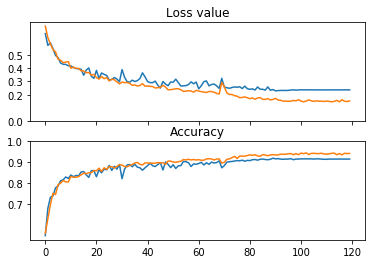

In [13]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0, 0.20, 0.30, 0.4, 0.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.7, 0.8, 0.9, 1.0])
plt.title('Accuracy',fontsize=12)
plt.show()

In [0]:
wrong_ans_index = []

for i in range(len(predout)):
    if predout[i] != testout[i]:
        wrong_ans_index.append(i)

In [0]:
wrong_ans_index = list(set(wrong_ans_index))

Showing 24 index image
Predicted as 0 but is actually 1


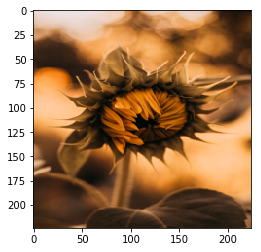

Showing 925 index image
Predicted as 1 but is actually 0


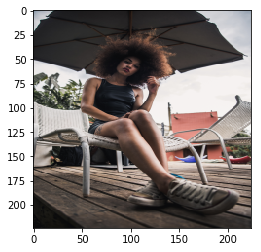

Showing 541 index image
Predicted as 1 but is actually 0


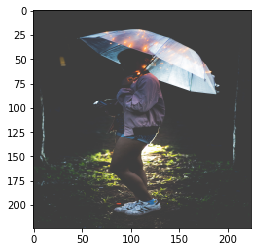

Showing 374 index image
Predicted as 0 but is actually 1


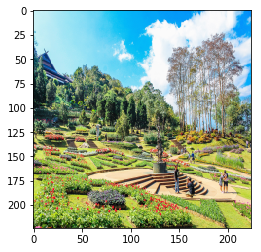

Showing 622 index image
Predicted as 1 but is actually 0


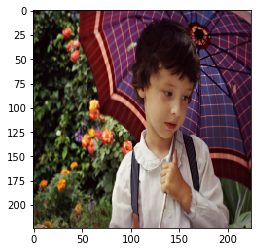

Showing 658 index image
Predicted as 1 but is actually 0


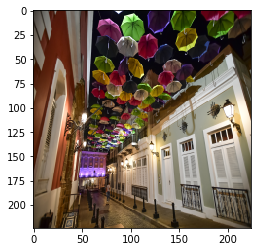

Showing 116 index image
Predicted as 0 but is actually 1


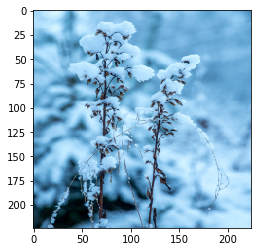

Showing 603 index image
Predicted as 1 but is actually 0


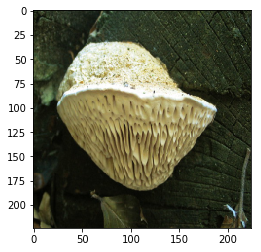

Showing 814 index image
Predicted as 1 but is actually 0


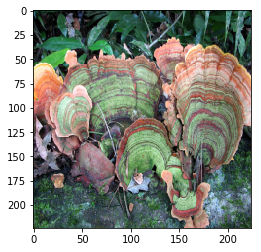

Showing 84 index image
Predicted as 0 but is actually 1


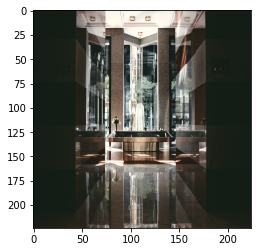

In [16]:
# Randomly show X examples of that was wrong

dataset = tsDatOrg #flowers #fungus #rocks

for index in range(10):
    index = wrong_ans_index[random.randint(0, len(wrong_ans_index)-1)]
    print("Showing %s index image" %(index))
    print("Predicted as %s but is actually %s" %(predout[index], testout[index]))
    imgplot = plt.imshow(data[index])
    plt.show()